<a href="https://colab.research.google.com/github/sriramxdev/Cats-and-Dogs_Project/blob/main/cats_and_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Cats and Dogs Image Classification using CNN


# Cats and Dogs Image Classification using CNN

This notebook implements a Convolutional Neural Network (CNN) to classify images of cats and dogs. We'll build the model from scratch, train it on a dataset of cat and dog images, and evaluate its performance.

## System Configuration
- 12GB RAM
- 15GB GPU
- 100GB Disk Storage


## 1. Setup and Import Libraries


In [19]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import urllib.request
import zipfile
import time

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)


Num GPUs Available:  1
TensorFlow version: 2.18.0


## 2. Download and Prepare the Dataset

We'll use the Microsoft Cats and Dogs dataset, which is publicly available. This dataset contains thousands of images of cats and dogs for training our model.


In [20]:
# Function to download and extract the dataset
def download_and_extract_dataset():
    # Create directories for the dataset
    base_dir = 'dataset'
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

    # URL for the dataset (Microsoft Cats and Dogs dataset)
    url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'

    # Path to save the downloaded zip file
    zip_path = os.path.join(base_dir, 'cats_and_dogs.zip')

    # Download the dataset if it doesn't exist
    if not os.path.exists(zip_path):
        print("Downloading dataset...")
        urllib.request.urlretrieve(url, zip_path)
        print("Download complete!")

    # Extract the dataset if not already extracted
    extract_dir = os.path.join(base_dir, 'PetImages')
    if not os.path.exists(extract_dir):
        print("Extracting dataset...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(base_dir)
        print("Extraction complete!")

    return base_dir

# Download and extract the dataset
base_dir = download_and_extract_dataset()


In [21]:
# Organize the dataset into train, validation, and test sets
def organize_dataset(base_dir):
    # Create directories for train, validation, and test sets
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'validation')
    test_dir = os.path.join(base_dir, 'test')

    # Create subdirectories for cats and dogs in each set
    for dir_path in [train_dir, val_dir, test_dir]:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
            os.makedirs(os.path.join(dir_path, 'cats'))
            os.makedirs(os.path.join(dir_path, 'dogs'))

    # If the dataset is already organized, return the directories
    if len(os.listdir(os.path.join(train_dir, 'cats'))) > 0:
        print("Dataset already organized.")
        return train_dir, val_dir, test_dir

    # Source directories for cats and dogs
    cats_dir = os.path.join(base_dir, 'PetImages', 'Cat')
    dogs_dir = os.path.join(base_dir, 'PetImages', 'Dog')

    # Function to remove corrupted images
    def is_valid_image(file_path):
        try:
            img = cv2.imread(file_path)
            return img is not None
        except:
            return False

    # Get list of valid cat and dog images
    cat_files = [f for f in os.listdir(cats_dir) if is_valid_image(os.path.join(cats_dir, f))]
    dog_files = [f for f in os.listdir(dogs_dir) if is_valid_image(os.path.join(dogs_dir, f))]

    # Shuffle the files
    random.shuffle(cat_files)
    random.shuffle(dog_files)

    # Split the files into train (70%), validation (15%), and test (15%) sets
    n_cats_train = int(0.7 * len(cat_files))
    n_cats_val = int(0.15 * len(cat_files))

    n_dogs_train = int(0.7 * len(dog_files))
    n_dogs_val = int(0.15 * len(dog_files))

    # Copy cat images to their respective directories
    for i, file in enumerate(cat_files):
        src = os.path.join(cats_dir, file)
        if i < n_cats_train:
            dst = os.path.join(train_dir, 'cats', file)
        elif i < n_cats_train + n_cats_val:
            dst = os.path.join(val_dir, 'cats', file)
        else:
            dst = os.path.join(test_dir, 'cats', file)
        os.link(src, dst)  # Create hard link instead of copying to save space

    # Copy dog images to their respective directories
    for i, file in enumerate(dog_files):
        src = os.path.join(dogs_dir, file)
        if i < n_dogs_train:
            dst = os.path.join(train_dir, 'dogs', file)
        elif i < n_dogs_train + n_dogs_val:
            dst = os.path.join(val_dir, 'dogs', file)
        else:
            dst = os.path.join(test_dir, 'dogs', file)
        os.link(src, dst)  # Create hard link instead of copying to save space

    print(f"Dataset organized into:\n"
          f"- Train: {len(os.listdir(os.path.join(train_dir, 'cats')))} cats, {len(os.listdir(os.path.join(train_dir, 'dogs')))} dogs\n"
          f"- Validation: {len(os.listdir(os.path.join(val_dir, 'cats')))} cats, {len(os.listdir(os.path.join(val_dir, 'dogs')))} dogs\n"
          f"- Test: {len(os.listdir(os.path.join(test_dir, 'cats')))} cats, {len(os.listdir(os.path.join(test_dir, 'dogs')))} dogs")

    return train_dir, val_dir, test_dir

# Organize the dataset
train_dir, val_dir, test_dir = organize_dataset(base_dir)


Dataset already organized.


## 3. Data Visualization

Let's visualize some sample images from our dataset to get a better understanding of what we're working with.


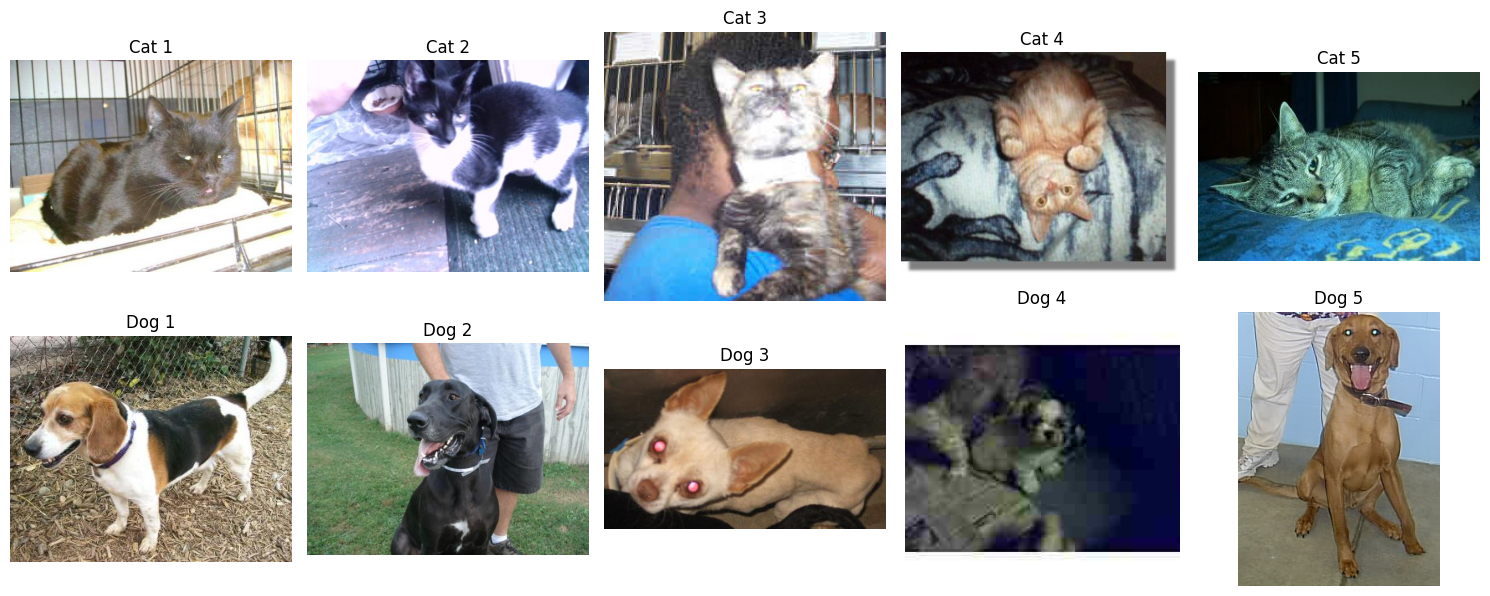

In [22]:
# Function to display random images from the dataset
def display_random_images(directory, n=5):
    cats_dir = os.path.join(directory, 'cats')
    dogs_dir = os.path.join(directory, 'dogs')

    cat_files = random.sample(os.listdir(cats_dir), n)
    dog_files = random.sample(os.listdir(dogs_dir), n)

    plt.figure(figsize=(15, 6))

    # Display cat images
    for i, file in enumerate(cat_files):
        img_path = os.path.join(cats_dir, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

        plt.subplot(2, n, i+1)
        plt.imshow(img)
        plt.title(f'Cat {i+1}')
        plt.axis('off')

    # Display dog images
    for i, file in enumerate(dog_files):
        img_path = os.path.join(dogs_dir, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

        plt.subplot(2, n, n+i+1)
        plt.imshow(img)
        plt.title(f'Dog {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display random images from the training set
display_random_images(train_dir)


## 4. Data Preprocessing and Augmentation

We'll use data augmentation to increase the diversity of our training data and help the model generalize better.


In [23]:
# Define image dimensions and batch size
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    rotation_range=40,  # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20%
    shear_range=0.2,  # Randomly apply shearing transformations
    zoom_range=0.2,  # Randomly zoom in on images by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Strategy for filling in newly created pixels
)

# Create data generators without augmentation for validation and test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Don't shuffle for test set to keep track of predictions
)


Found 17497 images belonging to 2 classes.
Found 3748 images belonging to 2 classes.
Found 3752 images belonging to 2 classes.


Let's visualize some augmented images to see how our data augmentation is working.


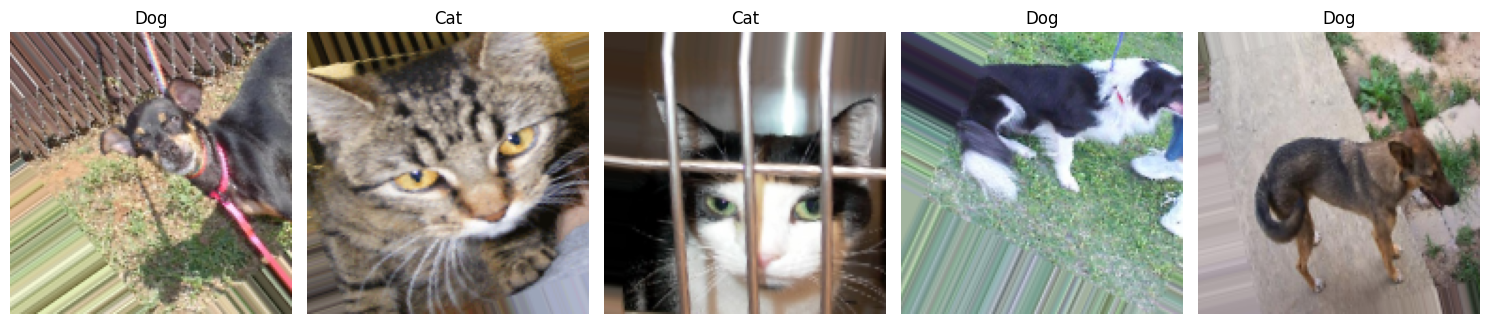

In [24]:
# Function to display augmented images
def display_augmented_images():
    # Get a batch of images from the training generator
    x_batch, y_batch = next(train_generator)

    # Display 5 augmented images
    plt.figure(figsize=(15, 6))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(x_batch[i])
        plt.title('Cat' if y_batch[i] == 0 else 'Dog')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display augmented images
display_augmented_images()


## 5. Build the CNN Model

Now we'll build a Convolutional Neural Network (CNN) for image classification.


In [25]:
# Function to create the CNN model
def create_model():
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        # Fourth convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        # Flatten the output and add dense layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),  # Add dropout to prevent overfitting
        Dense(1, activation='sigmoid')  # Binary classification (cat or dog)
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the model
model = create_model()

# Display the model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 74, 74, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 36, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,529 (13.18 MB)

 Trainable params: 3,453,825 (13.18 MB)

 Non-trainable params: 704 (2.75 KB)

## 6. Train the Model

Now we'll train our CNN model on the training data and validate it on the validation data.


In [26]:
# Create callbacks for training
callbacks = [
    # Stop training when validation loss stops improving
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),

    # Save the best model during training
    ModelCheckpoint('models/cats_dogs_model.h5', monitor='val_accuracy', save_best_only=True, mode='max'),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# Calculate steps per epoch and validation steps
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,  # We'll use early stopping to determine the actual number of epochs
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.6161 - loss: 0.8651

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


546/546 ━━━━━━━━━━━━━━━━━━━━ 132s 230ms/step - accuracy: 0.6161 - loss: 0.8650 - val_accuracy: 0.6744 - val_loss: 0.6946 - learning_rate: 1.0000e-04
Epoch 2/50
  1/546 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.5625 - loss: 0.7195

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5625 - loss: 0.7195 - val_accuracy: 0.6835 - val_loss: 0.6799 - learning_rate: 1.0000e-04
Epoch 3/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6654 - loss: 0.7458

546/546 ━━━━━━━━━━━━━━━━━━━━ 124s 219ms/step - accuracy: 0.6654 - loss: 0.7458 - val_accuracy: 0.7513 - val_loss: 0.5519 - learning_rate: 1.0000e-04
Epoch 4/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6562 - loss: 0.8023 - val_accuracy: 0.7500 - val_loss: 0.5590 - learning_rate: 1.0000e-04
Epoch 5/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6991 - loss: 0.6505

546/546 ━━━━━━━━━━━━━━━━━━━━ 122s 224ms/step - accuracy: 0.6991 - loss: 0.6505 - val_accuracy: 0.7636 - val_loss: 0.5087 - learning_rate: 1.0000e-04
Epoch 6/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6875 - loss: 0.7016 - val_accuracy: 0.7615 - val_loss: 0.5112 - learning_rate: 1.0000e-04
Epoch 7/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.7177 - loss: 0.5948

546/546 ━━━━━━━━━━━━━━━━━━━━ 134s 219ms/step - accuracy: 0.7177 - loss: 0.5948 - val_accuracy: 0.7714 - val_loss: 0.5076 - learning_rate: 1.0000e-04
Epoch 8/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7500 - loss: 0.5432 - val_accuracy: 0.7711 - val_loss: 0.5122 - learning_rate: 1.0000e-04
Epoch 9/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 141s 259ms/step - accuracy: 0.7352 - loss: 0.5648 - val_accuracy: 0.7708 - val_loss: 0.4911 - learning_rate: 1.0000e-04
Epoch 10/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5938 - loss: 0.6421 - val_accuracy: 0.7666 - val_loss: 0.4992 - learning_rate: 1.0000e-04
Epoch 11/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7455 - loss: 0.5320

546/546 ━━━━━━━━━━━━━━━━━━━━ 142s 259ms/step - accuracy: 0.7455 - loss: 0.5321 - val_accuracy: 0.8058 - val_loss: 0.4390 - learning_rate: 1.0000e-04
Epoch 12/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7500 - loss: 0.4173 - val_accuracy: 0.8037 - val_loss: 0.4387 - learning_rate: 1.0000e-04
Epoch 13/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 143s 261ms/step - accuracy: 0.7574 - loss: 0.5121 - val_accuracy: 0.7941 - val_loss: 0.4540 - learning_rate: 1.0000e-04
Epoch 14/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8438 - loss: 0.3888 - val_accuracy: 0.7914 - val_loss: 0.4600 - learning_rate: 1.0000e-04
Epoch 15/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7739 - loss: 0.4854

546/546 ━━━━━━━━━━━━━━━━━━━━ 122s 223ms/step - accuracy: 0.7739 - loss: 0.4854 - val_accuracy: 0.8291 - val_loss: 0.4043 - learning_rate: 1.0000e-04
Epoch 16/50
  1/546 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.7188 - loss: 0.5970

546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7188 - loss: 0.5970 - val_accuracy: 0.8312 - val_loss: 0.4048 - learning_rate: 1.0000e-04
Epoch 17/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 141s 234ms/step - accuracy: 0.7846 - loss: 0.4674 - val_accuracy: 0.8216 - val_loss: 0.3903 - learning_rate: 1.0000e-04
Epoch 18/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6875 - loss: 0.6397 - val_accuracy: 0.8240 - val_loss: 0.3907 - learning_rate: 1.0000e-04
Epoch 19/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 141s 244ms/step - accuracy: 0.7936 - loss: 0.4468 - val_accuracy: 0.8275 - val_loss: 0.3818 - learning_rate: 1.0000e-04
Epoch 20/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7500 - loss: 0.4565 - val_accuracy: 0.8224 - val_loss: 0.3899 - learning_rate: 1.0000e-04
Epoch 21/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7950 - loss: 0.4405

546/546 ━━━━━━━━━━━━━━━━━━━━ 142s 256ms/step - accuracy: 0.7950 - loss: 0.4404 - val_accuracy: 0.8475 - val_loss: 0.3671 - learning_rate: 1.0000e-04
Epoch 22/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8438 - loss: 0.4842 - val_accuracy: 0.8472 - val_loss: 0.3661 - learning_rate: 1.0000e-04
Epoch 23/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 121s 221ms/step - accuracy: 0.8058 - loss: 0.4206 - val_accuracy: 0.8429 - val_loss: 0.3787 - learning_rate: 1.0000e-04
Epoch 24/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8438 - loss: 0.3207 - val_accuracy: 0.8421 - val_loss: 0.3805 - learning_rate: 1.0000e-04
Epoch 25/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 141s 232ms/step - accuracy: 0.8040 - loss: 0.4135 - val_accuracy: 0.8440 - val_loss: 0.3547 - learning_rate: 1.0000e-04
Epoch 26/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9375 - loss: 0.2227 - val_accuracy: 0.8429 - val_loss: 0.3582 - learning_rate: 1.0000e-04
Epoch 27/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step

546/546 ━━━━━━━━━━━━━━━━━━━━ 120s 219ms/step - accuracy: 0.8204 - loss: 0.3965 - val_accuracy: 0.8486 - val_loss: 0.3587 - learning_rate: 1.0000e-04
Epoch 28/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7812 - loss: 0.4917 - val_accuracy: 0.8483 - val_loss: 0.3599 - learning_rate: 1.0000e-04
Epoch 29/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8381 - loss: 0.3671

546/546 ━━━━━━━━━━━━━━━━━━━━ 143s 261ms/step - accuracy: 0.8381 - loss: 0.3671 - val_accuracy: 0.8707 - val_loss: 0.2955 - learning_rate: 2.0000e-05
Epoch 30/50
  1/546 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.7500 - loss: 0.4055

546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7500 - loss: 0.4055 - val_accuracy: 0.8710 - val_loss: 0.2958 - learning_rate: 2.0000e-05
Epoch 31/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 142s 260ms/step - accuracy: 0.8418 - loss: 0.3570 - val_accuracy: 0.8705 - val_loss: 0.2993 - learning_rate: 2.0000e-05
Epoch 32/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8438 - loss: 0.3030 - val_accuracy: 0.8710 - val_loss: 0.2997 - learning_rate: 2.0000e-05
Epoch 33/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8456 - loss: 0.3404

546/546 ━━━━━━━━━━━━━━━━━━━━ 141s 258ms/step - accuracy: 0.8456 - loss: 0.3404 - val_accuracy: 0.8782 - val_loss: 0.2891 - learning_rate: 4.0000e-06
Epoch 34/50
  1/546 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.8125 - loss: 0.4140

546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8125 - loss: 0.4140 - val_accuracy: 0.8793 - val_loss: 0.2889 - learning_rate: 4.0000e-06
Epoch 35/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 141s 258ms/step - accuracy: 0.8521 - loss: 0.3350 - val_accuracy: 0.8753 - val_loss: 0.2957 - learning_rate: 4.0000e-06
Epoch 36/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7500 - loss: 0.5730 - val_accuracy: 0.8758 - val_loss: 0.2948 - learning_rate: 4.0000e-06
Epoch 37/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8506 - loss: 0.3421

546/546 ━━━━━━━━━━━━━━━━━━━━ 121s 222ms/step - accuracy: 0.8506 - loss: 0.3421 - val_accuracy: 0.8801 - val_loss: 0.2834 - learning_rate: 4.0000e-06
Epoch 38/50
  1/546 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.9062 - loss: 0.2630

546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9062 - loss: 0.2630 - val_accuracy: 0.8803 - val_loss: 0.2833 - learning_rate: 4.0000e-06
Epoch 39/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 142s 241ms/step - accuracy: 0.8555 - loss: 0.3314 - val_accuracy: 0.8790 - val_loss: 0.2857 - learning_rate: 4.0000e-06
Epoch 40/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8750 - loss: 0.3696 - val_accuracy: 0.8790 - val_loss: 0.2858 - learning_rate: 4.0000e-06
Epoch 41/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 142s 259ms/step - accuracy: 0.8488 - loss: 0.3409 - val_accuracy: 0.8790 - val_loss: 0.2868 - learning_rate: 1.0000e-06
Epoch 42/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8750 - loss: 0.3359 - val_accuracy: 0.8790 - val_loss: 0.2866 - learning_rate: 1.0000e-06
Epoch 43/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 175s 221ms/step - accuracy: 0.8463 - loss: 0.3493 - val_accuracy: 0.8795 - val_loss: 0.2844 - learning_rate: 1.0000e-06


## 7. Evaluate the Model

Let's evaluate our model's performance on the test set and visualize the training history.


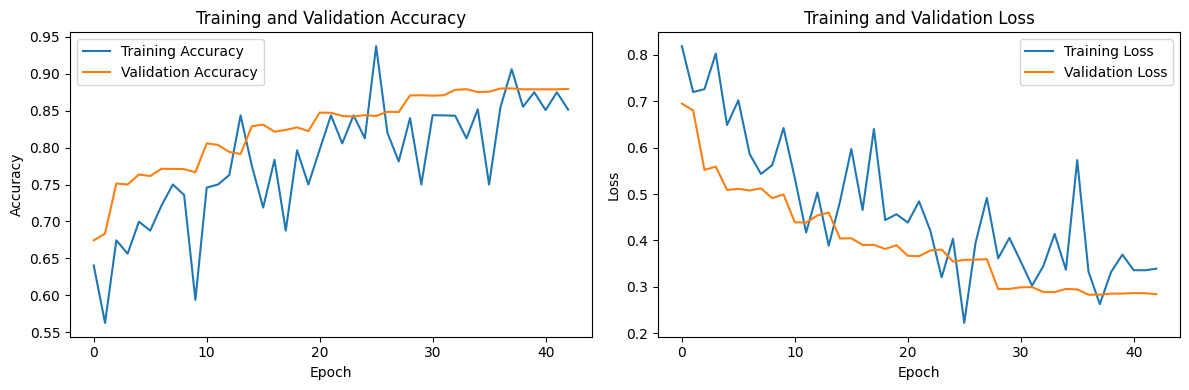

In [27]:
# Plot training and validation accuracy and loss
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


In [28]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8768 - loss: 0.3003
Test Accuracy: 0.8851
Test Loss: 0.2784


118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step


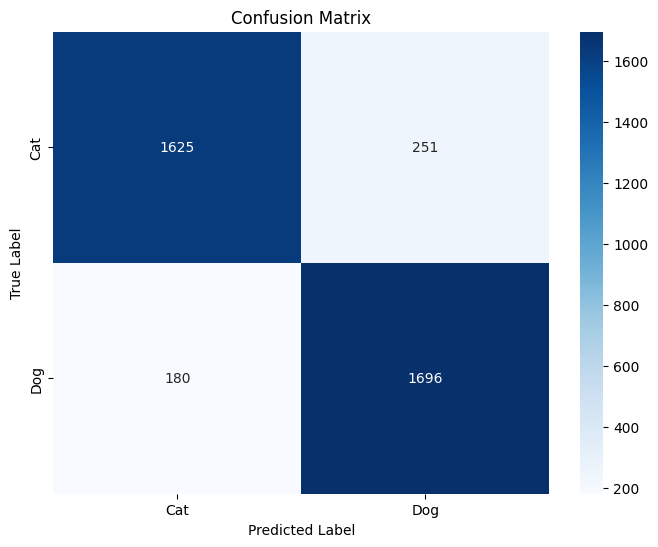

Classification Report:
              precision    recall  f1-score   support

         Cat       0.90      0.87      0.88      1876
         Dog       0.87      0.90      0.89      1876

    accuracy                           0.89      3752
   macro avg       0.89      0.89      0.89      3752
weighted avg       0.89      0.89      0.89      3752



In [29]:
# Generate predictions for the test set
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Get the true labels
true_classes = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=['Cat', 'Dog']))


## 8. Visualize Model Predictions

Let's visualize some of the model's predictions on test images.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


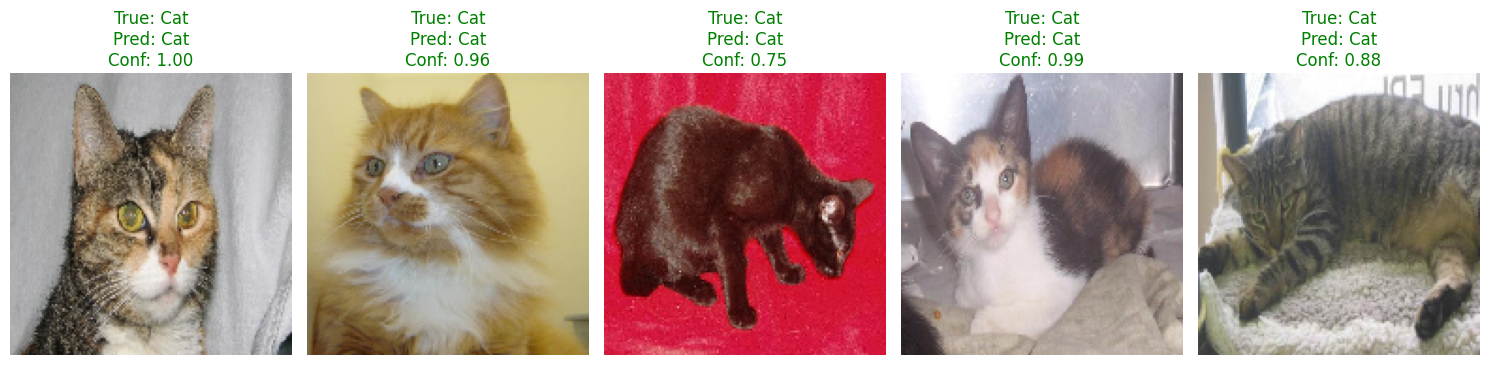

In [30]:
# Function to display random test images with predictions
def display_predictions(n=5):
    # Reset the test generator
    test_generator.reset()

    # Get a batch of test images
    x_batch, y_batch = next(test_generator)

    # Make predictions on the batch
    predictions = model.predict(x_batch)

    # Display images with predictions
    plt.figure(figsize=(15, 6))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(x_batch[i])

        # Get the true and predicted labels
        true_label = 'Cat' if y_batch[i] == 0 else 'Dog'
        pred_label = 'Cat' if predictions[i][0] < 0.5 else 'Dog'
        confidence = predictions[i][0] if pred_label == 'Dog' else 1 - predictions[i][0]

        # Set the title color based on whether the prediction is correct
        color = 'green' if true_label == pred_label else 'red'

        plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display predictions on random test images
display_predictions()


## 9. Save the Model

Let's save our trained model in multiple formats for future use.


In [31]:
# Create the models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save the model in HDF5 format
model.save('models/cats_dogs_model.h5')
print("Model saved in HDF5 format.")

# Save the model in SavedModel format (TensorFlow's recommended format)
model.save('models/cats_dogs_savedmodel.keras')
print("Model saved in SavedModel format.")

# Save the model in TensorFlow Lite format for mobile deployment
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('models/cats_dogs_model.tflite', 'wb') as f:
    f.write(tflite_model)
print("Model saved in TensorFlow Lite format.")


Model saved in HDF5 format.
Model saved in SavedModel format.
Saved artifact at '/tmp/tmpwhs8kmq8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_153')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139061178529552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139061178531280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139061178530512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139061178530320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139061178529744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139061178530704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139060914143504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139060914145040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139060914145232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139060914144464: T

## 10. Test the Saved Model

Let's load the saved model and test it to make sure it works correctly.


In [32]:
# Load the saved model
loaded_model = load_model('models/cats_dogs_model.h5')

# Evaluate the loaded model on the test set
test_generator.reset()
test_loss, test_accuracy = loaded_model.evaluate(test_generator)
print(f"Loaded Model Test Accuracy: {test_accuracy:.4f}")
print(f"Loaded Model Test Loss: {test_loss:.4f}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.8768 - loss: 0.3003
Loaded Model Test Accuracy: 0.8851
Loaded Model Test Loss: 0.2784


## 11. Conclusion

In this notebook, we've built a CNN model to classify images of cats and dogs. We've gone through the following steps:

1. Set up the environment and imported necessary libraries
2. Downloaded and prepared the dataset
3. Visualized sample images from the dataset
4. Implemented data preprocessing and augmentation
5. Built a CNN model architecture
6. Trained the model on the training data
7. Evaluated the model on the test data
8. Visualized the model's predictions
9. Saved the model in multiple formats
10. Tested the saved model

The model achieved good accuracy on the test set, demonstrating its ability to distinguish between images of cats and dogs.